<a href="https://colab.research.google.com/github/fire-long/24-1AI-ML/blob/main/240312%260314.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.3 데이터 가져오기

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok = True) #exist_ok 오타 주의
    url = "http://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path = Path("datasets"))
  return pd.read_csv("datasets/housing/housing.csv")

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


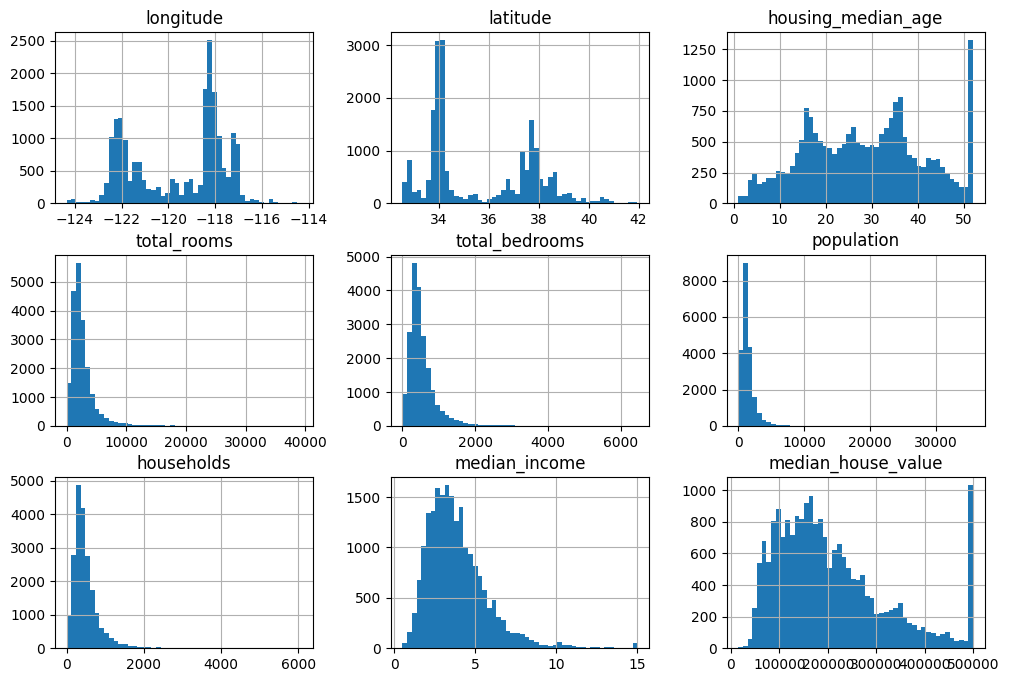

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [8]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices= shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [10]:
len(test_set)

4128

In [11]:
from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [15]:
import sys

#노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/fronted select Noninteractive'|debconf-set-selections
  #나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)
  #나눔바른곧기 폰트로 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  #마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [16]:
plt.rc('font',family='NanumBarunGothic')

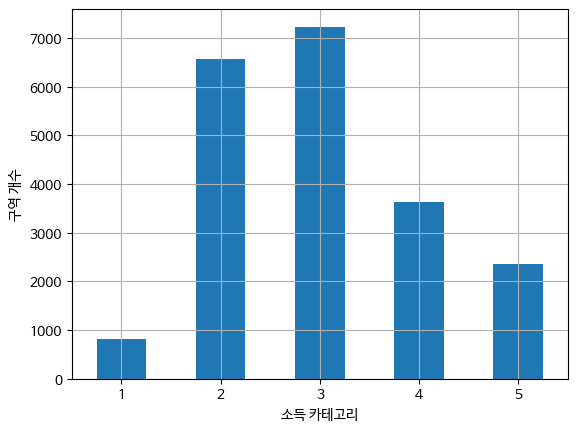

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [19]:
#첫번째 분할
strat_train_set, strat_test_set = strat_splits[0]
#하나의 분할이 필요한 경우 train_test_split()함수와 stratify 매개변수 사용
strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify=housing["income_cat"], random_state=42)

In [20]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [21]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True) #계층적 샘플링을 위해 만들었던 칼럼을 삭제

# 2.4 데이터 이해를 위한 탐색과 시각화

In [22]:
housing = strat_train_set.copy() #원본을 위해서

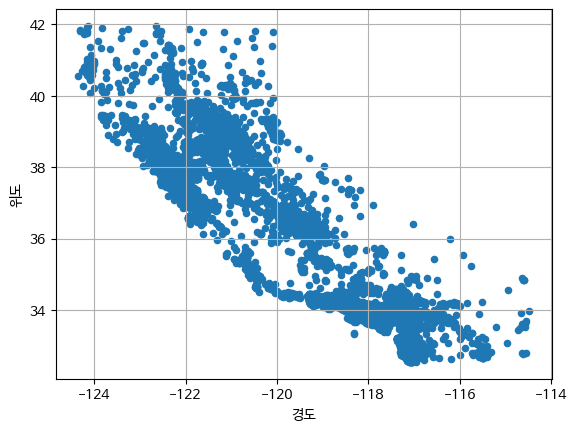

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

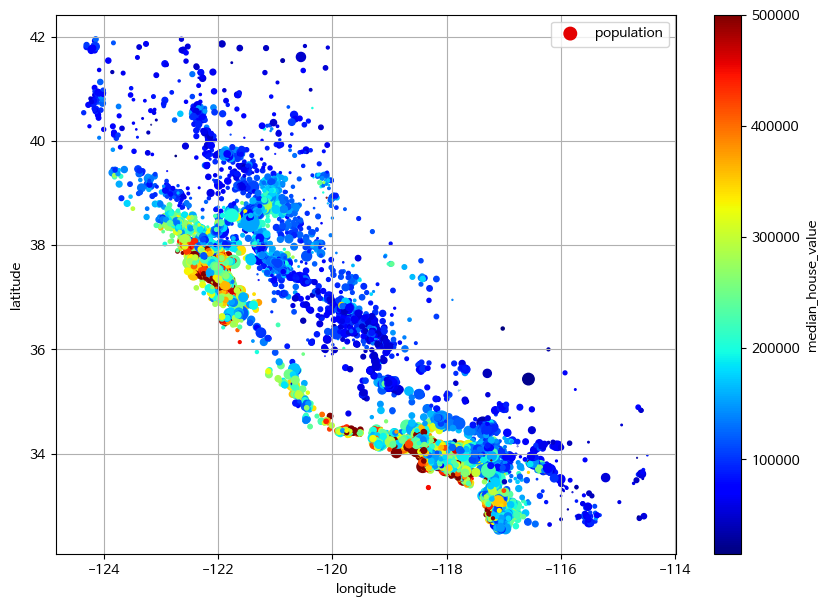

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid = True,
             s=housing["population"]/100, label="population", c="median_house_value",
             cmap = "jet", colorbar = True, legend = True, sharex=False, figsize=(10, 7))
plt.show()

In [26]:
corr_matrix = housing.corr(numeric_only = True)

In [27]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

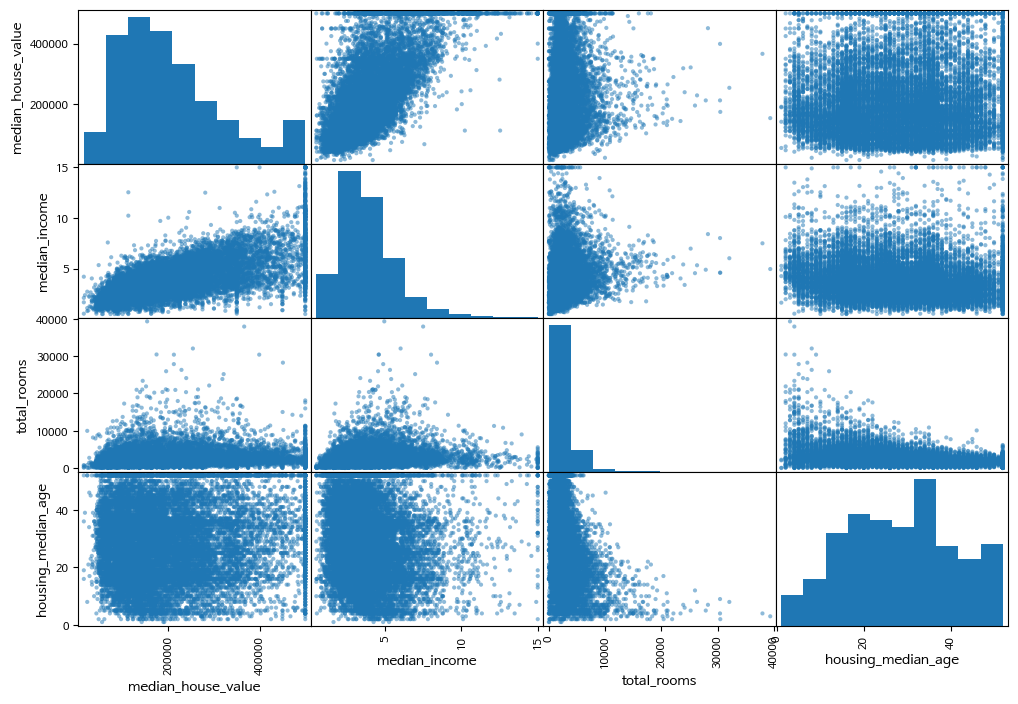

In [30]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

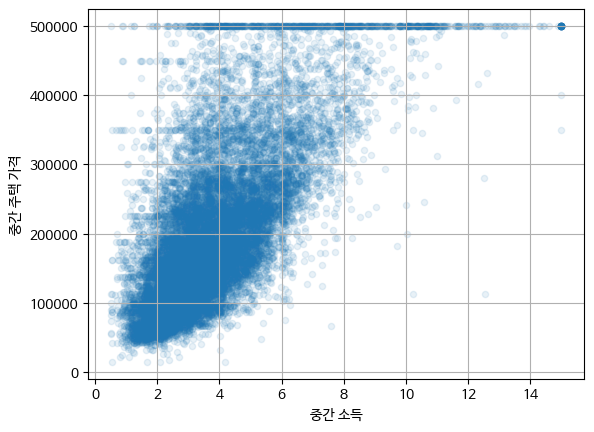

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.xlabel("중간 소득")
plt.ylabel("중간 주택 가격")
plt.show()

In [34]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_home"] = housing["population"]/housing["households"]

In [35]:
corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_house        0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
population_per_home   -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

# 2.5 머신러닝 알고리즘을 위한 데이터 준비

## 2.5.1 데이터 정제

In [39]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [40]:
#option 1
#housing.dropna(subset=["total_bedrooms"], inplace = True)
#option 2
#housing.drop("total_bedrooms", axis = 1, inplace = True)
#option 3
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace = True)

위의 option 3와 동일한 기능 구현

In [45]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [46]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [47]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [48]:
X = imputer.transform(housing_num)

In [49]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns,
                          index=housing_num.index)

## 2.5.2 텍스트와 범주형 특성 다루기

In [50]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [51]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder =OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [52]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [53]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from